# Nationwide Application Assessment for Computational Telematics
# Jason Barkeloo

Now let's import necessary libraries. <br>
numpy for various linear algebra libraries<br>
pandas for convenient file reading as well as dataframe structures that are convenient to work with<br>
matplotlib for various basic plots<br>
geopy for geodesic distances used for calculations in part 1
sklearn, keras (using locally installed tensorflow) for neural network applications

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import sys
import sklearn
import keras
from sklearn.model_selection import train_test_split
from keras.models import Model,Sequential
from keras.layers import Dense, Dropout, Input
from keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import xgboost as xgb

# Part 1: GPS Data
## (1) What steps did you take to clean the data?
To clean the data let's start by looking at it to see any abnormalities

In [5]:
sample_trips = pd.read_csv("C:/Users/JTBar/Documents/Telematics Exercise Files/sample_trips.csv")

This dataset 'sample_trips.csv' contains 9687 rows of data and 4 columns containing the information on 16 different trips (trip_nb), the local date time (local_dtm), latitude and longitudinal coordinates.  I'm reading it into a pandas dataframe for ease of use.

For the most part the change from one row of local_dtm to the next suggest a rate of 1Hz data collection, however ##many times## this data has a longer sampling rate.  

In [6]:
sample_trips

,trip_nb,local_dtm,latitude,longitude
0,1,19MAY17:07:33:59,40.037952,-83.071342
1,1,19MAY17:07:34:01,40.038181,-83.071274
2,1,19MAY17:07:34:02,40.038349,-83.071304
3,1,19MAY17:07:34:03,40.038448,-83.071266
4,1,19MAY17:07:34:04,40.038551,-83.071236
...,...,...,...,...
9682,16,23MAY17:19:58:05,40.029373,-83.095665
9683,16,23MAY17:19:58:07,40.029633,-83.095161
9684,16,23MAY17:19:58:08,40.029678,-83.095093
9685,16,23MAY17:19:58:09,40.029701,-83.094910


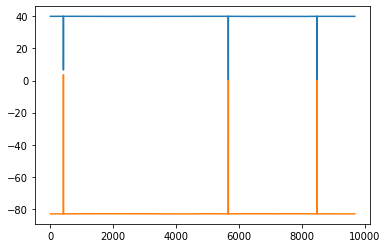

In [7]:
sample_trips.latitude.plot()
sample_trips.longitude.plot()

In [11]:
sample_trips[410:416].latitude, sample_trips[410:416].longitude

(410    40.064465
 411     6.620114
 412     6.620117
 413     6.620116
 414     6.620114
 415    40.064507
 Name: latitude, dtype: float64,
 410   -83.078590
 411     3.587174
 412     3.587173
 413     3.587172
 414     3.587175
 415   -83.079872
 Name: longitude, dtype: float64)

In [12]:
sample_trips[5660:5665].latitude, sample_trips[5660:5665].longitude

(5660    40.063885
 5661     0.000000
 5662     0.000000
 5663    40.063862
 5664    40.063858
 Name: latitude, dtype: float64,
 5660   -83.064537
 5661     0.000000
 5662     0.000000
 5663   -83.064003
 5664   -83.063843
 Name: longitude, dtype: float64)

In [13]:
sample_trips[8480:8485].latitude, sample_trips[8480:8485].longitude

(8480    40.039795
 8481    40.039890
 8482     0.000000
 8483     0.000000
 8484    40.040298
 Name: latitude, dtype: float64,
 8480   -83.071190
 8481   -83.071175
 8482     0.000000
 8483     0.000000
 8484   -83.071129
 Name: longitude, dtype: float64)

## Cleaning data
Here the latitude and longitude cleaning is done.  The latitude cleaning is done first and should pick up all of the misplaced points as both gps coordinates are erroneous in these cases, the longitude is done still for completeness.  The latitude and longitude are required to be within 2 degrees of the median.  This allows the individual trips to be in an area a little over the size of the state of ohio.  I am assuming that the purpose of the data is to check day-to-day driving habits and not particularly long road trips.  This is a simplistic method based on looking at the data but achieves the goal

In [14]:
sample_trips_filtered = sample_trips[(np.abs(sample_trips['latitude']-sample_trips.latitude.median())<2.)]
sample_trips_filtered = sample_trips_filtered[(np.abs(sample_trips_filtered['longitude']-sample_trips_filtered.longitude.median())<2.)]
sample_trips_filtered = sample_trips_filtered.reset_index(drop=True)

It can be seen now that the latitude and longitude plots do not have any nonsensical jumps, let's dig a little deeper into these trips to see if anything else needs to be cleaned up (i.e. gps drift while at rest or large gps jumps that are inconsistent with the current rate of travel). 

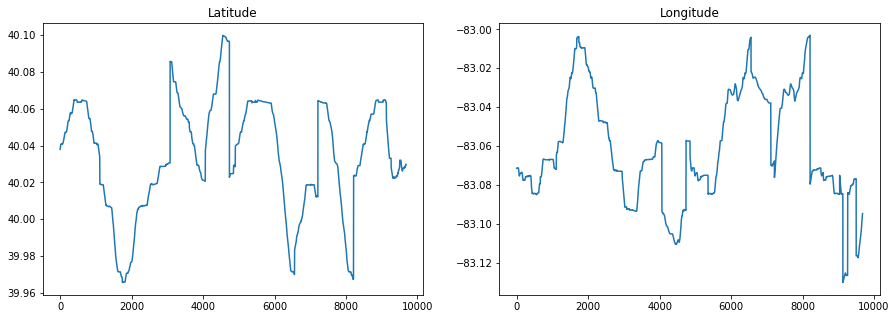

In [15]:
fig,axs = plt.subplots(1,2,figsize=(15,5))
sample_trips_filtered.latitude.plot(ax=axs[0],title="Latitude")
sample_trips_filtered.longitude.plot(ax=axs[1],title="Longitude")

Starting to look at the timesteps, first lets change them to a datetime stamp thats a little more intuitive:

In [16]:
sample_trips_filtered['local_dtm']=pd.to_datetime(sample_trips_filtered['local_dtm'],format='%d%b%y:%H:%M:%S')

## Adding in some information to the dataframe based on the latitudude, longitude, timestamps to do analysis on more physically meaningful variables 
The variables being added are the change in position ('DeltaPos (mi)') and time ('DeltaTime (hr)') between two datapoints.  The Speed in miles per hour ('Speed MPH') and acceleration in miles per hour per second ('Accel MPHPS') are also calculated using very basic physics relationships (i.e. speed is change in position per time, instantaneous acceleration is change in speed per time.

The DeltaPos is calculated using the geodesic function from the geopy package in which the default ellipsoid used to model the earth is the standard WGS-84 ellipsoid.  Geopy documentation can be found here: https://geopy.readthedocs.io/en/stable/

In [17]:
sample_trips_filtered['DeltaPos (mi)']=np.nan
sample_trips_filtered.loc[0,'DeltaPos (mi)']=0
sample_trips_filtered.loc[0,'Speed MPH']=0
sample_trips_filtered.loc[0,'Accel MPHPS']=0
sample_trips_filtered.loc[1,'Accel MPHPS']=0
sample_trips_filtered['local_dtm']=pd.to_datetime(sample_trips_filtered['local_dtm'],format='%d%b%y:%H:%M:%S')
#a['DeltaTime']=pd.to_datetime(a['local_dtm'],infer_datetime_format=True)
sample_trips_filtered.loc[0,'DeltaTime (hr)']=0
for i in range(1,len(sample_trips_filtered)):
    sample_trips_filtered.loc[i,'DeltaPos (mi)']=geodesic((sample_trips_filtered.loc[i-1,'latitude'],sample_trips_filtered.loc[i-1,'longitude']),(sample_trips_filtered.loc[i,'latitude'],sample_trips_filtered.loc[i,'longitude'])).miles 
    sample_trips_filtered.loc[i,'DeltaTime (hr)']=pd.Timedelta(sample_trips_filtered.loc[i,'local_dtm']-sample_trips_filtered.loc[i-1,'local_dtm']).seconds/3600.
    sample_trips_filtered.loc[i,'Speed MPH']=sample_trips_filtered.loc[i,'DeltaPos (mi)']/sample_trips_filtered.loc[i,'DeltaTime (hr)']
    if i>1: #need a delta v to calculate instantaneous acceleration otherwise nonsensical information, Not great to check every iteration but sufficient
        sample_trips_filtered.loc[i,'Accel MPHPS']=(sample_trips_filtered.loc[i,'Speed MPH']-sample_trips_filtered.loc[i-1,'Speed MPH'])/(sample_trips_filtered.loc[i,'DeltaTime (hr)']*3600.)
    #

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


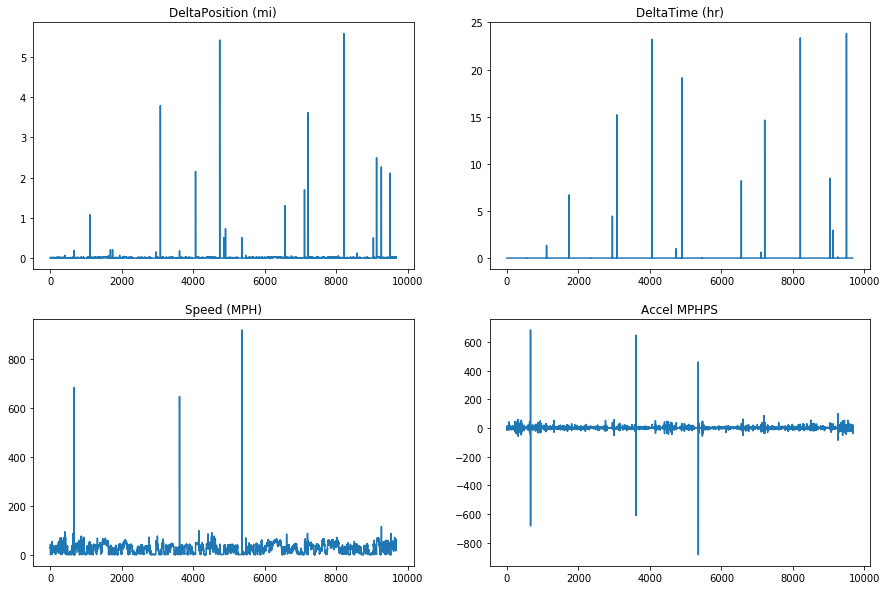

In [12]:
fig,axs = plt.subplots(2,2,figsize=(15,10))
sample_trips_filtered['DeltaPos (mi)'].plot(ax=axs[0,0],title="DeltaPosition (mi)")
sample_trips_filtered['DeltaTime (hr)'].plot(ax=axs[0,1],title="DeltaTime (hr)")
sample_trips_filtered['Speed MPH'].plot(ax=axs[1,0],title="Speed (MPH)")
sample_trips_filtered['Accel MPHPS'].plot(ax=axs[1,1],title='Accel MPHPS')

# Further issues for cleaning consideration
From these plots we can infer 2 issues.  First, from the DeltaPosition and DeltaTime plots there are a large number of drifts.  These drifts account for gps drift between trips. One can count the peaks, in particular in DeltaTime and see there are 15 visible peaks which in addition to the first trip are the 16 total trips accounted for in the dataset.  This can be shown quantitatively by looking at the amount of times the DeltaTime between two points is greater than 36 seconds (0.01hours).  These points should not cause issues in estimations of speed and number of hard acceleration events.  This is implied because they do not show up in the speed and acceleration plots and I can look at trips individually which after further cleaning will be self consistent to themselves.

Secondly, it can see  speed and acceleration plots something odd is going on in at least 3 further points by the points that seem unphysical (i.e. hundreds of mph/s accelerations which are then mirrored or speeds well in excess of 600mph.  These points come from errors in reading for a few seconds.  These points need to be dealt while.

A third issue comes when the DeltaTime between two events is 0, this could easily occur if the recording device has an error in the frequency at which it records, i.e. if the frequency drops below 1Hz and you take two readings within a second.  To deal with the additional points will be dropped. The alternative is averaging the longitude,latitude values but as any single second will be a small change the average would not have much of an effect that isnt averaged out in the acceleration.  It would be more computationally appropriate to check the timestamps first and average the indices that way however as an exercise I feel it is important to show how I came about this solution and the order in which I decided to clean the events.

In [18]:
print(sample_trips_filtered[sample_trips_filtered['DeltaTime (hr)']>0.01].index,'\n Number of time intervals greater than 36seconds (0.01hr):', len(sample_trips_filtered[sample_trips_filtered['DeltaTime (hr)']>0.1].index))

Int64Index([ 563, 1109, 1680, 1741, 2350, 2951, 3078, 4062, 4738, 4851, 4901,
            5467, 6559, 7111, 7213, 8210, 9038, 9128, 9261, 9501],
           dtype='int64') 
 Number of time intervals greater than 36seconds (0.01hr): 15


## Further Cleaning
Here is a list of the times there is 0 change in time from the previous recorded datapoint.  It seems to happen in smallish clusters for the most part just by looking at the indices.  The first point is obviously ok as it is the initial time period and DeltaTime (hr) was initialized to 0 by myself.  This happens 24 additional times

Now that we will filter out the repeat time points and remake the dataframe with the speed/acceleration etc

In [19]:
coincidenceList = sample_trips_filtered[sample_trips_filtered['DeltaTime (hr)']==0.].index
print(coincidenceList[1:])
sample_trips_filtered2=sample_trips_filtered.drop(sample_trips_filtered.index[coincidenceList[1:]])
sample_trips_filtered2 = sample_trips_filtered2.reset_index(drop=True)

sample_trips_filtered2['DeltaPos (mi)']=np.nan
sample_trips_filtered2.loc[0,'DeltaPos (mi)']=0
sample_trips_filtered2.loc[0,'Speed MPH']=0
sample_trips_filtered2.loc[0,'Accel MPHPS']=0
sample_trips_filtered2.loc[1,'Accel MPHPS']=0
#sample_trips_filtered2['local_dtm']=pd.to_datetime(sample_trips_filtered2['local_dtm'],format='%d%b%y:%H:%M:%S')
sample_trips_filtered2.loc[0,'DeltaTime (hr)']=0
for i in range(1,len(sample_trips_filtered2)):
    sample_trips_filtered2.loc[i,'DeltaPos (mi)']=geodesic((sample_trips_filtered2.loc[i-1,'latitude'],sample_trips_filtered2.loc[i-1,'longitude']),(sample_trips_filtered2.loc[i,'latitude'],sample_trips_filtered2.loc[i,'longitude'])).miles 
    sample_trips_filtered2.loc[i,'DeltaTime (hr)']=pd.Timedelta(sample_trips_filtered2.loc[i,'local_dtm']-sample_trips_filtered2.loc[i-1,'local_dtm']).seconds/3600.
    sample_trips_filtered2.loc[i,'Speed MPH']=sample_trips_filtered2.loc[i,'DeltaPos (mi)']/sample_trips_filtered2.loc[i,'DeltaTime (hr)']
    if i>1: #need a delta v to calculate instantaneous acceleration otherwise nonsensical information, Not great to check every iteration but sufficient
        sample_trips_filtered2.loc[i,'Accel MPHPS']=(sample_trips_filtered2.loc[i,'Speed MPH']-sample_trips_filtered2.loc[i-1,'Speed MPH'])/(sample_trips_filtered2.loc[i,'DeltaTime (hr)']*3600.)
    #

Int64Index([ 712,  722,  726,  744,  926, 4148, 4153, 4274, 4341, 4547, 4566,
            4720, 4726, 4731, 6747, 6748, 6749, 6750, 7207, 8720, 8722, 8790,
            8792, 9003],
           dtype='int64')


Let's look around these points in speed, the acceleration curve and mirroring will be taken care of if the speed/position issues are removed.  These are caused by GPS Jumps to a new base point.  Just removing these events would not take care of the issue as the base point has drifted and recalculating the speeds/accelerations after the removal would show the same issues, perhaps even exaggerated more depending on the jumps.
One potential solution is to interpolate the speed at the odd indices manually by the speed on either side.  We 

In [20]:
print(len(sample_trips_filtered2[sample_trips_filtered2['Speed MPH']>100.].index))
for i in sample_trips_filtered2[sample_trips_filtered2['Speed MPH']>100.].index:
    print(sample_trips_filtered2.loc[i-1:i+1])

4
     trip_nb           local_dtm   latitude  longitude  DeltaPos (mi)  \
660        1 2017-05-19 07:47:41  40.064354 -83.079346       0.000000   
661        1 2017-05-19 07:47:42  40.064281 -83.075768       0.189742   
662        1 2017-05-19 07:47:43  40.064281 -83.075768       0.000000   

      Speed MPH  Accel MPHPS  DeltaTime (hr)  
660    0.000000     0.000000        0.000278  
661  683.070781   683.070781        0.000278  
662    0.000000  -683.070781        0.000278  
      trip_nb           local_dtm   latitude  longitude  DeltaPos (mi)  \
3608        5 2017-05-20 12:27:19  40.052776 -83.067070       0.000000   
3609        5 2017-05-20 12:27:20  40.050175 -83.066933       0.179601   
3610        5 2017-05-20 12:27:21  40.050034 -83.066940       0.009735   

       Speed MPH  Accel MPHPS  DeltaTime (hr)  
3608    0.000000     0.000000        0.000278  
3609  646.564407   646.564407        0.000278  
3610   35.046997  -611.517410        0.000278  
      trip_nb           loca

In [21]:
print(len(sample_trips_filtered2[sample_trips_filtered2['DeltaPos (mi)']>1.].index))
#for i in sample_trips_filtered2[sample_trips_filtered2['DeltaPos (mi)']>1.].index:
#    print(sample_trips_filtered2.loc[i-1:i+1]);

11


In [22]:
sample_trips_filtered2[(sample_trips_filtered2['Speed MPH']>100.) & (np.abs(sample_trips_filtered2['Accel MPHPS'])>30)].index

Int64Index([661, 3609, 5341, 9239], dtype='int64')

In [23]:
sample_trips_filtered2[(np.abs(sample_trips_filtered2['Accel MPHPS'])>40)].index

Int64Index([  52,  227,  274,  275,  301,  302,  311,  312,  315,  393,  394,
             404,  405,  635,  639,  661,  662,  721,  722,  724,  929, 1311,
            2754, 2989, 2990, 3609, 3610, 4143, 4144, 4149, 4400, 4463, 4510,
            4511, 4606, 5341, 5342, 5455, 5456, 5460, 5461, 6597, 6598, 7177,
            7195, 8488, 9239, 9240, 9368, 9369, 9420, 9468, 9513, 9652],
           dtype='int64')

Find the points that we want to adapt.  In this dataset they coincide with excessive speed as well as excessive acceleration.  The maximal acceleration by the cars is around 20-25mphps so a large buffer is given to this and the additional speed requirement is required as the acceleration at such a speed would be lower.  Go through, interpolate the speed at those points and recalculate the accleration for the entire dataframe

In [25]:
changeList = sample_trips_filtered2[(sample_trips_filtered2['Speed MPH']>100.) & (np.abs(sample_trips_filtered2['Accel MPHPS'])>30)].index
print('Indices to be changed: ',changeList)
sample_trips_filtered3=sample_trips_filtered2.copy()
for index in changeList:
    sample_trips_filtered3.loc[index,'Speed MPH']=(sample_trips_filtered3.loc[index-1,'Speed MPH']+sample_trips_filtered3.loc[index+1,'Speed MPH'])/2
for i in range(2,len(sample_trips_filtered3)):
    sample_trips_filtered3.loc[i,'Accel MPHPS']=(sample_trips_filtered3.loc[i,'Speed MPH']-sample_trips_filtered3.loc[i-1,'Speed MPH'])/(sample_trips_filtered3.loc[i,'DeltaTime (hr)']*3600.)
 

Indices to be changed:  Int64Index([661, 3609, 5341, 9239], dtype='int64')


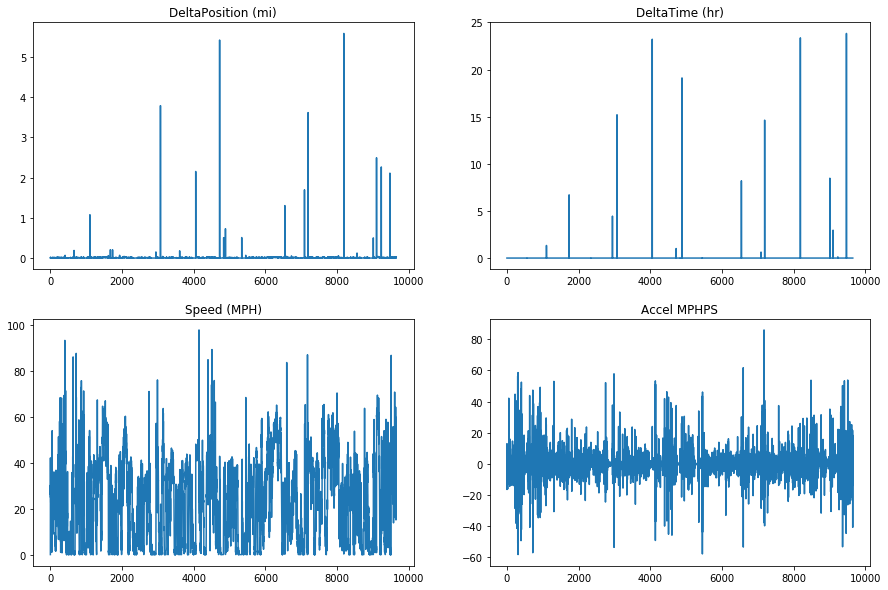

In [26]:
fig,axs = plt.subplots(2,2,figsize=(15,10))
sample_trips_filtered3['DeltaPos (mi)'].plot(ax=axs[0,0],title="DeltaPosition (mi)")
sample_trips_filtered3['DeltaTime (hr)'].plot(ax=axs[0,1],title="DeltaTime (hr)")
sample_trips_filtered3['Speed MPH'].plot(ax=axs[1,0],title="Speed (MPH)")
sample_trips_filtered3['Accel MPHPS'].plot(ax=axs[1,1],title='Accel MPHPS')

Here are the results after very basic data cleaning has been applied to remove unphysical events.  For the most part this puts the speed data within both legal possible realms.  Before I start classifying I want to apply a mild rolling average to the speeds and recalculate the accelerations to help remove some of the noise while keeping the general structure.

In [27]:
sample_trips_filtered3['SpeedAvg']=sample_trips_filtered3.loc[:,'Speed MPH'].rolling(window=3).mean()
sample_trips_filtered3['AccelAvg3']=sample_trips_filtered3.loc[:,'Accel MPHPS'].rolling(window=3).mean()

for i in range(2,len(sample_trips_filtered3)):
    sample_trips_filtered3.loc[i,'AccelAvg']=(sample_trips_filtered3.loc[i,'SpeedAvg']-sample_trips_filtered3.loc[i-1,'SpeedAvg'])/(sample_trips_filtered3.loc[i,'DeltaTime (hr)']*3600.)

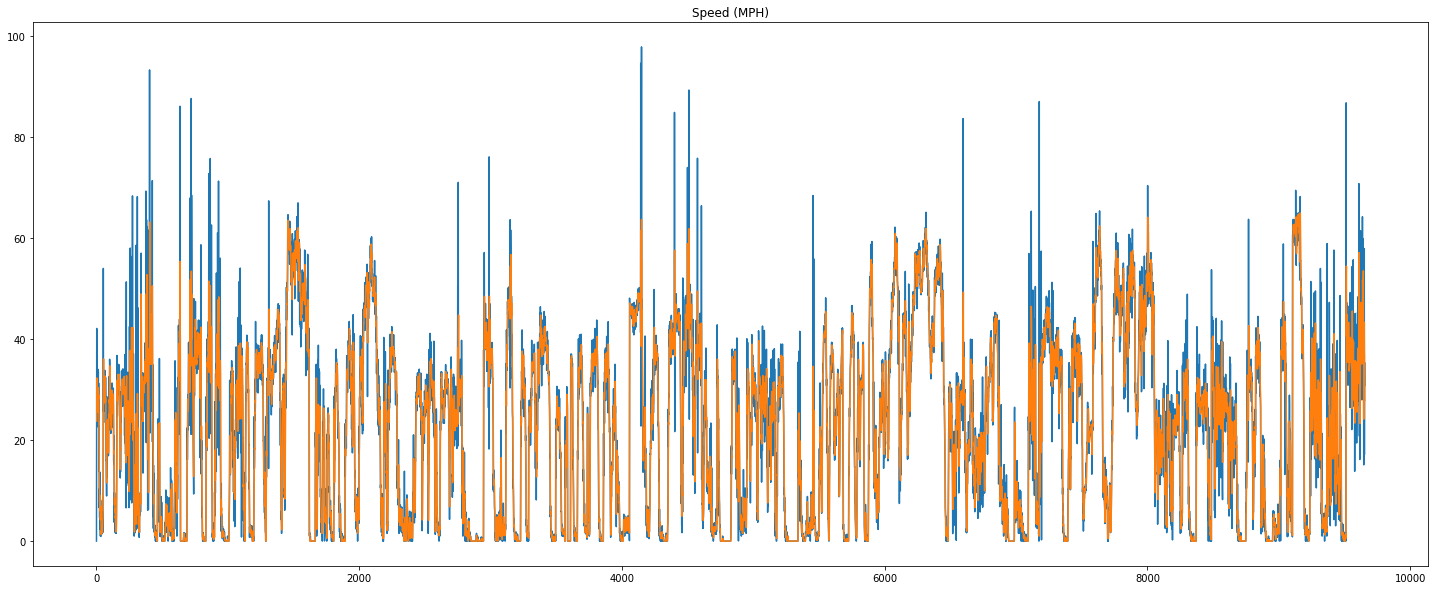

In [28]:
fig,axs = plt.subplots(1,1,figsize=(25,10))
sample_trips_filtered3['Speed MPH'].plot(title="Speed (MPH)")
sample_trips_filtered3['SpeedAvg'].plot(title="Speed (MPH)")

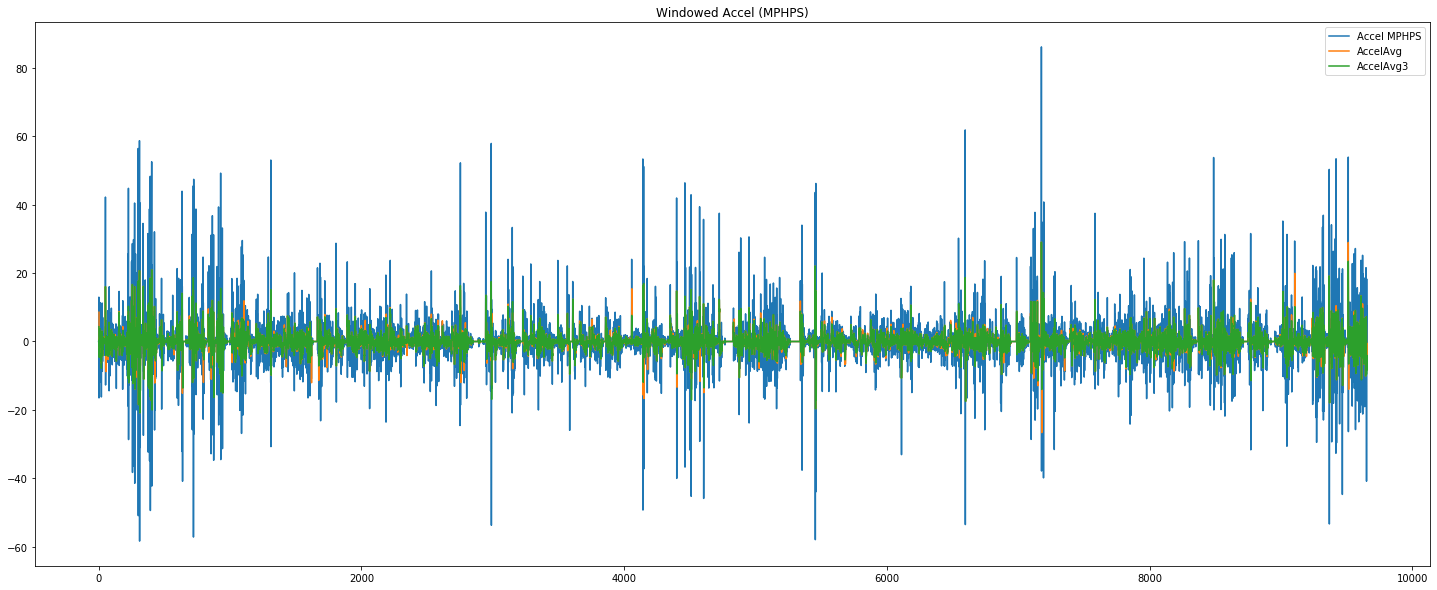

In [29]:
fig,axs = plt.subplots(1,1,figsize=(25,10))
sample_trips_filtered3['Accel MPHPS'].plot(title="Accel (MPHPS)")
sample_trips_filtered3['AccelAvg'].plot(title="Windowed Accel (MPHPS)")
sample_trips_filtered3['AccelAvg3'].plot(title="Windowed Accel (MPHPS)")
plt.legend()

# Trip by Trip Investigations

In [30]:
#Loading each individual trip into its own object to further examine each trip on an individual basis
# 
trip_dict={}
for trip_id in range(1,17):
    trip_dict[str(trip_id)]=sample_trips_filtered3[sample_trips_filtered3.trip_nb == trip_id]
    #Also need to reset DeltaTime between trips
    trip_dict[str(trip_id)].loc[(trip_dict[str(trip_id)].head(1).index[0],'DeltaTime (hr)')]=0.

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


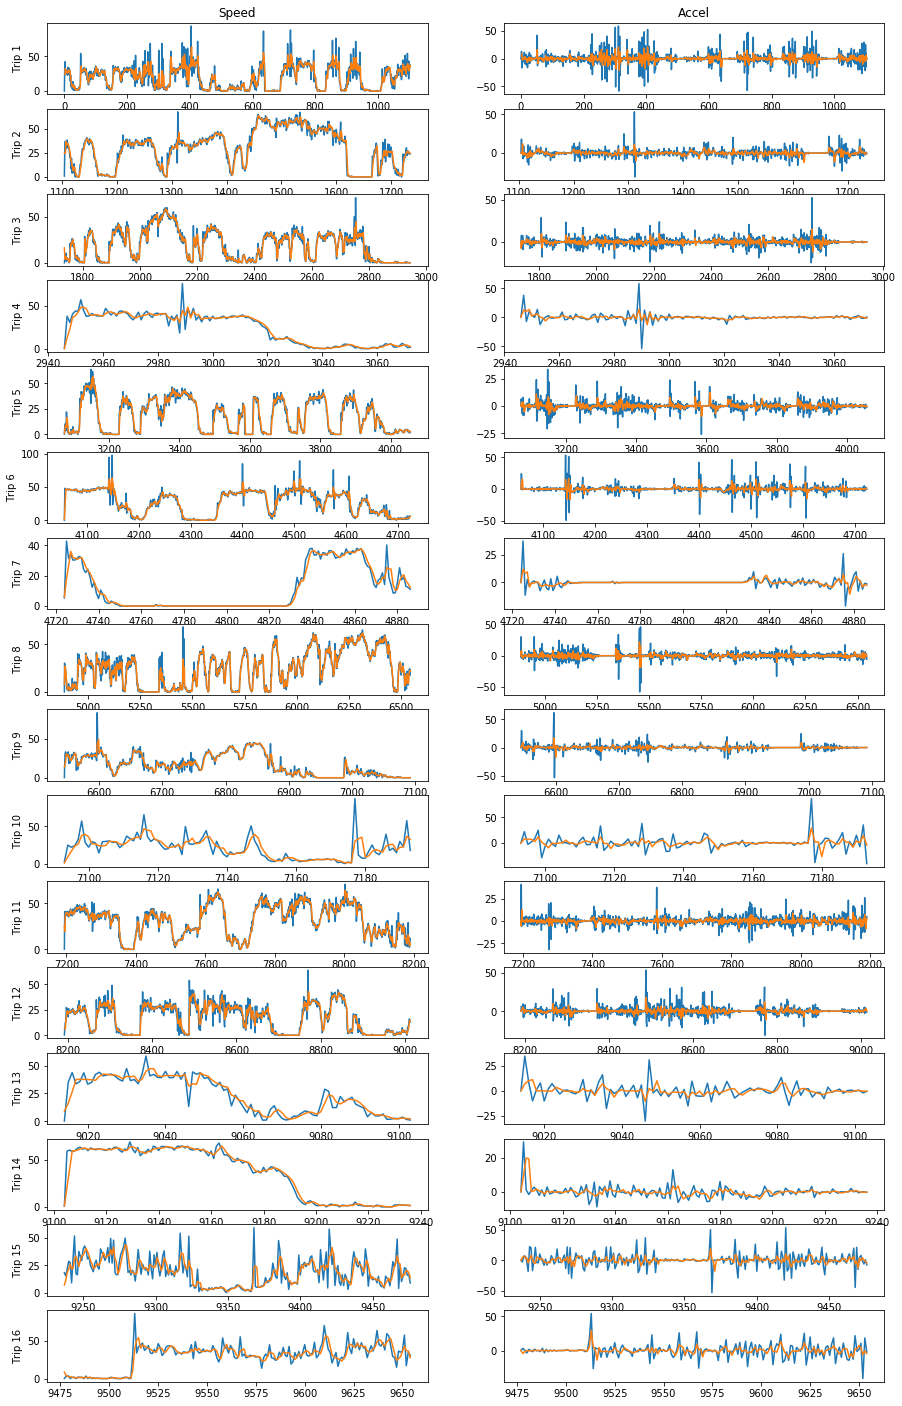

In [31]:
fig,axs = plt.subplots(16,2,figsize=(15,25))
for i in range(1,17):
    axs[0,0].set_title('Speed')
    axs[0,1].set_title('Accel')
    axs[i-1,0].set_ylabel('Trip '+str(i))
    trip_dict[str(i)]['Speed MPH'].plot(ax=axs[i-1,0])
    trip_dict[str(i)]['SpeedAvg'].plot(ax=axs[i-1,0])
    trip_dict[str(i)]['Accel MPHPS'].plot(ax=axs[i-1,1])
    trip_dict[str(i)]['AccelAvg'].plot(ax=axs[i-1,1])

# Setting a Threshold for hard events (braking and acceleration) baed on the data.
## Hard Braking Events
Having no a priori intuition about numbers to use for hard braking and acceleration events I first looked up some baseline numbers
Some definitions need to be worked out i.e. what am I considering a hard event.  After some brief cursory research I've found a negative acceleration at around 7mph/s and up to 15mph/s to be standard for 18 wheelers (https://www.michiganautolaw.com/blog/2017/11/05/hard-braking/).  If we use this minimal value as a hard braking cutoff it will be the number of times the acceleration is calculated at <-7mph/s
## Hard Acceleration Events
For hard accelerations I'm going to set my threshold based on 0-60 times for typical cars, let's take a mid 2000s Corolla for example the 0-60 time is around 8 seconds (https://www.zeroto60times.com/vehicle-make/toyota-0-60-mph-times/).  If we allow for some buffer room above this i.e. around 10 seconds instead of 8 for a hard cutoff on hard accelerations it would be the number of events where the acceleration is above 6mph/s.  I would certainly consider the maximum acceleration for a vehicle in proper working order to be more than a hard acceleration event. However, I recognize that this is very depedent upon the vehicle i.e., a loaded down smart car is most likely incapable of a hard acceleration which by itself could lead to unsafety as hard accelerations can be used to avoid incidents.  Using the averaged value in a window of 3 seconds should be sufficient without smearing out the largest acceleration and braking events.
## Idle Time
Time spent below while moving with an average (window=3) speed less than 1mph, allows moderate drift while stopped

Now, lets compare how these reference hard acceleration numbers compare to the average acceleration and average braking  values

0.06975110539512015
2.710460667334003


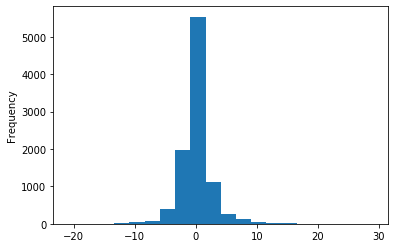

In [32]:
sample_trips_filtered3['AccelAvg3'].plot.hist(bins=20)
print(sample_trips_filtered3['AccelAvg3'].mean())
print(sample_trips_filtered3['AccelAvg3'].std())

In [33]:
print("Average Positive Acceleration: ",sample_trips_filtered3[sample_trips_filtered3['AccelAvg3']>0.]['AccelAvg3'].mean())
print("Standard Deviation: ",sample_trips_filtered3[sample_trips_filtered3['AccelAvg3']>0.]['AccelAvg3'].std())

Average Positive Acceleration:  1.71086711388756
Standard Deviation:  2.381725409735693


In [34]:
print("Average Negative Acceleration: ",sample_trips_filtered3[sample_trips_filtered3['AccelAvg3']<0.]['AccelAvg3'].mean())
print("Standard Deviation: ",sample_trips_filtered3[sample_trips_filtered3['AccelAvg3']<0.]['AccelAvg3'].std())

Average Negative Acceleration:  -1.6224397530057804
Standard Deviation:  1.9791184661984416


So, the average acceleration (using the window=3 rolilng average) is 1.71mph/s compared to the hard acceleration estimation I found to be around 6-7.5 mph/s.  The average braking acceleration (-1.62mph/s) compared to the -7mph/s.  For simplicity going forward I will use assume that the distribution of accelerations is normal enough that I can assume a half normal distribution and use the mean+2standard deviations for acceleration threshold and mean-2standard deviations for the braking acceleration threshold.

## Thresholds - Acceleration: 6.47mph/s, Braking: -5.58mph/s

Lets create a few helper functions to return the amount of hard acceleration events, hard braking events, total idle time, and total distance traveled.  For hard braking and acceleration I am choosing to use the rolling average value and count peaks above my above determined threshold to get individual events and not just the time within those events

In [35]:
def GetHardEvents(df,threshold,AccelBrake):
    sign = 1
    if AccelBrake == "Accel":
        sign =1
    elif AccelBrake == "Brake":
        sign =-1
    peaks=0
    for i in range(df.head(1).index[0]+1,df.tail(1).index[0]-1):
        if sign*df.AccelAvg3[i]>sign*df.AccelAvg3[i-1]:
            if sign*df.AccelAvg3[i]>sign*df.AccelAvg3[i+1]:
                if sign*df.AccelAvg3[i]>threshold:
                    #print(i)
                    peaks+=1
    return peaks

def GetIdleTotalTime(df):
    IdleTime, TotalTime=0.,0.
    try: #handles exception in case of 0 idle time as defined below
        IdleTime = df['DeltaTime (hr)'][(df['SpeedAvg'])<1.].cumsum().iloc[-1]
    except IndexError:
        print("No Idle Time for this Trip")
    TotalTime = df['DeltaTime (hr)'].cumsum().iloc[-1]
    return IdleTime*60, TotalTime*60

def GetIntegralDistance(df):
    distance=0
    distance= df['DeltaPos (mi)'].cumsum()
    return distance.iloc[-1]
    

# Summary of Trips

In [37]:
for i in range(1,17):
    print("Trip: ", str(i))
    print('\t Hard Accel Events: %i '%(GetHardEvents(trip_dict[str(i)],6.47,"Accel")))
    print('\t Hard Brake Events: %i '%(GetHardEvents(trip_dict[str(i)],5.58,"Brake")))
    print('\t Idle Time: %.2f min, \t Total Time: %.2f min'%(GetIdleTotalTime(trip_dict[str(i)])))
    print('\t Distance Traveled: %.2f mi \n'%(GetIntegralDistance(trip_dict[str(i)])))

Trip:  1
	 Hard Accel Events: 47 
	 Hard Brake Events: 40 
	 Idle Time: 3.05 min, 	 Total Time: 22.25 min
	 Distance Traveled: 6.83 mi 

Trip:  2
	 Hard Accel Events: 7 
	 Hard Brake Events: 5 
	 Idle Time: 1.15 min, 	 Total Time: 13.03 min
	 Distance Traveled: 7.29 mi 

Trip:  3
	 Hard Accel Events: 10 
	 Hard Brake Events: 11 
	 Idle Time: 3.45 min, 	 Total Time: 24.45 min
	 Distance Traveled: 7.77 mi 

Trip:  4
	 Hard Accel Events: 3 
	 Hard Brake Events: 1 
	 Idle Time: 0.23 min, 	 Total Time: 2.33 min
	 Distance Traveled: 1.06 mi 

Trip:  5
	 Hard Accel Events: 10 
	 Hard Brake Events: 5 
	 Idle Time: 3.07 min, 	 Total Time: 18.70 min
	 Distance Traveled: 9.75 mi 

Trip:  6
	 Hard Accel Events: 18 
	 Hard Brake Events: 10 
	 Idle Time: 0.90 min, 	 Total Time: 12.60 min
	 Distance Traveled: 7.83 mi 

Trip:  7
	 Hard Accel Events: 3 
	 Hard Brake Events: 1 
	 Idle Time: 1.48 min, 	 Total Time: 4.03 min
	 Distance Traveled: 6.55 mi 

Trip:  8
	 Hard Accel Events: 11 
	 Hard Brake Eve

# Part 2 Modeling

In [78]:
sim_sum_tot = pd.read_csv(r"C:\Users\JTBar\Documents\Telematics Exercise Files\simulated_summary_total.csv")

In [79]:
sim_sum_tot.head()

,Vehicle,Days,Distance,HardBrakes,HardAccelerations,NightTime_Pct,VehicleType,Loss
0,1,365,13114,152,56,0.005,SUV,0
1,2,365,18707,147,1,0.010,SUV,0
2,3,365,16659,151,127,0.019,Truck,0
3,4,365,13330,126,147,0.000,SUV,1
4,5,365,22533,10,11,0.001,Truck,0


In [80]:
sim_sum_tot.groupby(['VehicleType'])['Loss'].count()

VehicleType
Car         9085
Minivan     1520
SUV         7463
Truck      11932
Name: Loss, dtype: int64


This dataset contains 30,000 vehicles, of which 4031 have been in a collision.  For a further breakdown of how many vehicles have been in a collision by VehicleType:

In [86]:
sim_sum_tot.groupby(['VehicleType','Loss'])['Loss'].count()

VehicleType  Loss
Car          0        7955
             1        1130
Minivan      0        1365
             1         155
SUV          0        6368
             1        1095
Truck        0       10281
             1        1651
Name: Loss, dtype: int64

# (4) Is there a statistically significant difference between vehicle types?
If we assume the loss populations are sampled from a binomial distribution with probability given by TotalLossPerType/TotalType a simple z-test can be conducted to determine if the null hypothesis, the distributions being 'sampled' from a similar distribution, can be rejected.  For a significance $\alpha = 0.05$ a z-value greater than the critical value of 1.64 means the null hypothesis is rejected and the population proportions are statistically significantly different at the 0.05 significance level. 
\begin{equation*}
z   = \frac{p_1 - p_2}{\sqrt{p (1-p)(1/n_1 + 1/n_2)}}
\end{equation*}

In [95]:
ProbDict={}
ProbDict['Car']     = [1130.,9085.];
ProbDict['Minivan'] = [155.,1520.] ;
ProbDict['SUV']     = [1095.,7463.];
ProbDict['Truck']   = [1651.,11932.];
ProbDict

{'Car': [1130.0, 9085.0],
 'Minivan': [155.0, 1520.0],
 'SUV': [1095.0, 7463.0],
 'Truck': [1651.0, 11932.0]}

In [102]:
def calculateZ(ProbDict,Vehicle1,Vehicle2):
    #Takes the total sample size of two distributions and number of 'favorable' cases here the Loss and returns a z-test value
    n1=ProbDict[Vehicle1][1]
    x1=ProbDict[Vehicle1][0]
    n2=ProbDict[Vehicle2][1]
    x2=ProbDict[Vehicle2][0]
    p1 = x1/n1
    p2 = x2/n2
    p  = (x1+x2)/(n1+n2)
    z  = np.abs(p1-p2)/np.sqrt(p*(1-p)*(1/n1+1/n2))
    print('z value for %s and %s: %.2f'%(Vehicle1,Vehicle2,z))
    return z
for key in ProbDict:
    for key2 in ProbDict:
        if key !=key2:
            calculateZ(ProbDict,key,key2)
    

z value for Car and Minivan: 2.48
z value for Car and SUV: 4.19
z value for Car and Truck: 2.96
z value for Minivan and Car: 2.48
z value for Minivan and SUV: 4.59
z value for Minivan and Truck: 3.92
z value for SUV and Car: 4.19
z value for SUV and Minivan: 4.59
z value for SUV and Truck: 1.62
z value for Truck and Car: 2.96
z value for Truck and Minivan: 3.92
z value for Truck and SUV: 1.62


## Applying this z test for all possible combinations all combinations can be said to be statistically significant except for the combination of populations of Trucks and SUVs

# (5) Are hard brakes and hard accelerations equally important in predicting risks?

In [9]:
print("Hard Brakes per Loss Event: %.2f"%(sim_sum_tot[sim_sum_tot['Loss']>0]['HardBrakes'].cumsum().iloc[-1]/len(sim_sum_tot[sim_sum_tot['Loss']>0])))
print("Hard Accelerations per Loss Event: %.2f"%(sim_sum_tot[sim_sum_tot['Loss']>0]['HardAccelerations'].cumsum().iloc[-1]/len(sim_sum_tot[sim_sum_tot['Loss']>0])))

Hard Brakes per Loss Event: 170.24
Hard Accelerations per Loss Event: 138.25


In [10]:
print("Hard Brakes per 0 Loss Event: %.2f"%(sim_sum_tot[sim_sum_tot['Loss']==0]['HardBrakes'].cumsum().iloc[-1]/len(sim_sum_tot[sim_sum_tot['Loss']==0])))
print("Hard Accelerations per 0 Loss Event: %.2f"%(sim_sum_tot[sim_sum_tot['Loss']==0]['HardAccelerations'].cumsum().iloc[-1]/len(sim_sum_tot[sim_sum_tot['Loss']==0])))

Hard Brakes per 0 Loss Event: 167.44
Hard Accelerations per 0 Loss Event: 104.53


In [10]:
sim_sum_tot.describe()

,Vehicle,Days,Distance,HardBrakes,HardAccelerations,NightTime_Pct,Loss
count,30000.000000,30000.0,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,365.0,13617.042533,167.818933,109.059367,0.029745,0.134367
std,8660.398374,0.0,4271.179182,560.504807,401.525915,0.054900,0.341052
min,1.000000,365.0,2488.000000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,365.0,10550.000000,40.000000,20.000000,0.001000,0.000000
50%,15000.500000,365.0,13206.000000,98.000000,58.000000,0.007000,0.000000
75%,22500.250000,365.0,16231.000000,206.000000,132.000000,0.033000,0.000000
max,30000.000000,365.0,35159.000000,35639.000000,38221.000000,0.888000,1.000000


In [11]:
#Split data into vehicle cases with/without loss
loss_df = sim_sum_tot[sim_sum_tot['Loss']==1] #Vehicle with indicated collision
noloss_df=sim_sum_tot[sim_sum_tot['Loss']==0] #Vehicle without collision history

# Model
This model will be employeeing a densely connected feed forward neural network for event classification
Activation functions: 
    rectified linear unit (ReLU) activation function such that the gradients of activation functions will not diminish as you increase the depth of the network
    sigmoid activation function is applied to the output layer as is standard for classification problems
    
Loss/Response Function:
    Binary Cross Entropy will be used to calculate the predicted probability (probability of correct classification based on the input values)  Larger predicted probabilites correspond to lower response function values for correctly identified events.

Optimization Function:
    Adam (Adaptive moment estimation) Optimizer which is the standard efficient optimization function that calulates adaptive learning rates for all parameters in the network.  It computes exponentially weighted averages of past gradients and squares of gradients
    
I'll split up the input dataset into 2 dataframes, X:the useful input values (dropping Loss as it is the classifier, Vehicle which is effectively an index, and Days which is 365 for every row, and y: the truth value of loss prediction

In [12]:
sim_sum_tot = sim_sum_tot.replace("Car", 0)
sim_sum_tot = sim_sum_tot.replace("SUV", 1)
sim_sum_tot = sim_sum_tot.replace("Truck", 2)
sim_sum_tot = sim_sum_tot.replace("Minivan", 3)

X = sim_sum_tot.drop(['Loss','Vehicle', 'Days'], axis=1)
y = sim_sum_tot['Loss']

In [13]:
#splitting up the signal and background datasets into training sets, testing sets, and validation sets. 
#This splits into 64% to be used for training and 16% testing and 16% validation
ix = range(y.shape[0]) 
X_train, X_test, y_train, y_test, ix_train, ix_test = train_test_split(X, y, ix, train_size=0.8)
X_train, X_val,y_train, y_val,ix_train, ix_val=train_test_split(X_train,y_train,ix_train,test_size=0.2)

In [15]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [16]:
def DNNmodel(Input_shape=(10,), n_hidden=1, n_nodesHidden=20, dropout=0.2, optimizer='adam'):
        inputs=Input(shape=Input_shape)
        i=0
        if n_hidden>0:
                hidden=Dense(n_nodesHidden, activation='relu')(inputs)
                hidden=Dropout(dropout)(hidden)
                i+=1
        while i<n_hidden:
                hidden=Dense(n_nodesHidden, activation='relu')(hidden)
                hidden=Dropout(dropout)(hidden)
                i+=1
        outputs = Dense(1,activation='sigmoid')(hidden)
        model = Model(inputs,outputs)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        model.summary()
        return model

In [17]:
model = DNNmodel(Input_shape=(5,),n_hidden=2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                120       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 561
Trainable par

In [18]:
model.fit(X_train,y_train,epochs=50,callbacks=[EarlyStopping(verbose=True,patience=10,monitor='val_loss')], validation_data=(X_val, y_val),batch_size=10)


Train on 19200 samples, validate on 4800 samples
Epoch 1/50
19200/19200 [==============================] - 2s 90us/step - loss: 0.4240 - accuracy: 0.8608 - val_loss: 0.3948 - val_accuracy: 0.8658
Epoch 2/50
19200/19200 [==============================] - 1s 77us/step - loss: 0.3975 - accuracy: 0.8658 - val_loss: 0.3924 - val_accuracy: 0.8658
Epoch 3/50
19200/19200 [==============================] - 1s 77us/step - loss: 0.3931 - accuracy: 0.8659 - val_loss: 0.3928 - val_accuracy: 0.8658
Epoch 4/50
19200/19200 [==============================] - 1s 77us/step - loss: 0.3924 - accuracy: 0.8660 - val_loss: 0.3901 - val_accuracy: 0.8656
Epoch 5/50
19200/19200 [==============================] - 1s 77us/step - loss: 0.3930 - accuracy: 0.8658 - val_loss: 0.3887 - val_accuracy: 0.8658
Epoch 6/50
19200/19200 [==============================] - 2s 78us/step - loss: 0.3902 - accuracy: 0.8659 - val_loss: 0.3902 - val_accuracy: 0.8658
Epoch 7/50
19200/19200 [==============================] - 2s 79us/st

In [19]:
history = model.history.history
print("history keys: ", history.keys())

history keys:  dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


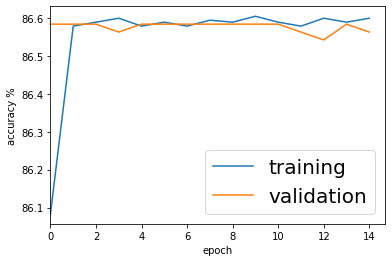

In [20]:
#Accuracy plot
plt.plot(100 * np.array(history['accuracy']), label='training')
plt.plot(100 * np.array(history['val_accuracy']), label='validation')
plt.xlim(0)
plt.xlabel('epoch')
plt.ylabel('accuracy %')
plt.legend(loc='lower right', fontsize=20)


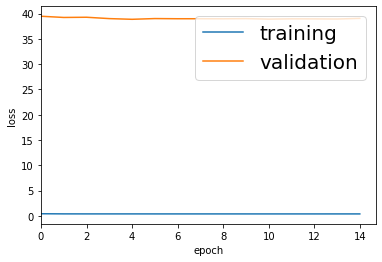

In [21]:
#loss plot
plt.plot(np.array(history['loss']), label='training')
plt.plot(100 * np.array(history['val_loss']), label='validation')
plt.xlim(0)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right', fontsize=20)

In [22]:
max(model.predict(X_val))

array([0.56721604], dtype=float32)

In [23]:
yhat = model.predict(X_test, verbose = True, batch_size = 512) 

6000/6000 [==============================] - 0s 1us/step


In [24]:
yhat_cls = np.argmax(yhat, axis=1)

In [25]:
yhat_cls

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

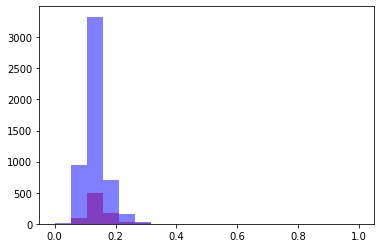

In [26]:
bins = np.linspace(0, 1, 20)
_ = plt.hist(yhat[y_test==1], histtype='stepfilled', alpha=0.5, color='red', label=r"Signal", bins=bins)
_ = plt.hist(yhat[y_test==0], histtype='stepfilled', alpha=0.5, color='blue', label=r'Background', bins=bins)

# Resampling, NN part 2
Let's try to do some resampling using Adaptive Synthetic Sampling, focuses on data that are hard to learn 
https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.ADASYN.html

In [27]:
from imblearn.over_sampling import ADASYN
adasyn = ADASYN(sampling_strategy="auto")
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)
np.bincount(y_train_adasyn)

array([16626, 16166], dtype=int64)

In [28]:
model = DNNmodel(Input_shape=(5,),n_hidden=2)
model.fit(X_train_adasyn,y_train_adasyn,epochs=50,callbacks=[EarlyStopping(verbose=True,patience=10,monitor='val_loss')], validation_data=(X_val, y_val),batch_size=10)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 5)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 20)                120       
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 20)                420       
_________________________________________________________________
dropout_4 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 21        
Total params: 561
Trainable params: 561
Non-trainable params: 0
_____________________________________________________________

history keys:  dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


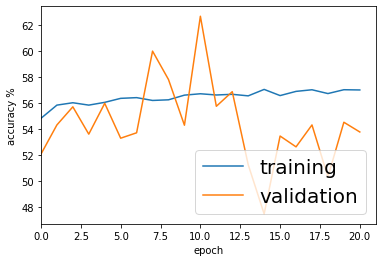

In [29]:
history = model.history.history
print("history keys: ", history.keys())
#Accuracy plot
plt.plot(100 * np.array(history['accuracy']), label='training')
plt.plot(100 * np.array(history['val_accuracy']), label='validation')
plt.xlim(0)
plt.xlabel('epoch')
plt.ylabel('accuracy %')
plt.legend(loc='lower right', fontsize=20)

6000/6000 [==============================] - 0s 8us/step


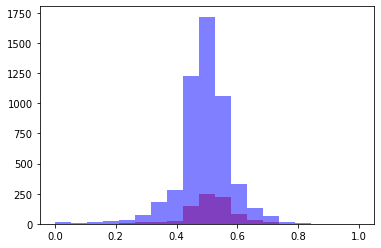

In [30]:
yhat = model.predict(X_test, verbose = True, batch_size = 512) 
yhat_cls = np.argmax(yhat, axis=1)
sum(yhat_cls)
bins = np.linspace(0, 1, 20)
_ = plt.hist(yhat[y_test==1], histtype='stepfilled', alpha=0.5, color='red', label=r"Signal", bins=bins)
_ = plt.hist(yhat[y_test==0], histtype='stepfilled', alpha=0.5, color='blue', label=r'Background', bins=bins)

In [31]:
print("Loss Events: mean: %.3f, std: %.3f" %(yhat[y_test==1].mean(),yhat[y_test==1].std()))
print("NoLoss Events: mean: %.3f, std: %.3f" %(yhat[y_test==0].mean(),yhat[y_test==0].std()))

Loss Events: mean: 0.513, std: 0.083
NoLoss Events: mean: 0.492, std: 0.086


# Resampling using SMOTE
Synthetic minority oversampling technique (Smote) generates fake data that is similar to, but not exactly like the minority class using nearest-neightbors approach to fill in space between neighbors.

In [32]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy="auto")
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
np.bincount(y_train_smote)

array([16626, 16626], dtype=int64)

In [33]:
model = DNNmodel(Input_shape=(5,),n_hidden=2)
model.fit(X_train_smote,y_train_smote,epochs=50,callbacks=[EarlyStopping(verbose=True,patience=10,monitor='val_loss')], validation_data=(X_val, y_val),batch_size=10)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 5)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 20)                120       
_________________________________________________________________
dropout_5 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 20)                420       
_________________________________________________________________
dropout_6 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 21        
Total params: 561
Trainable params: 561
Non-trainable params: 0
_____________________________________________________________

history keys:  dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


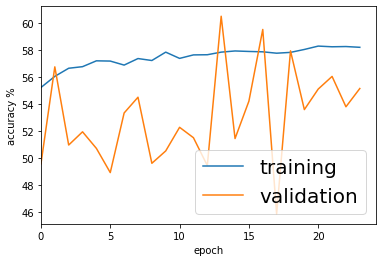

In [34]:
history = model.history.history
print("history keys: ", history.keys())
#Accuracy plot
plt.plot(100 * np.array(history['accuracy']), label='training')
plt.plot(100 * np.array(history['val_accuracy']), label='validation')
plt.xlim(0)
plt.xlabel('epoch')
plt.ylabel('accuracy %')
plt.legend(loc='lower right', fontsize=20)

6000/6000 [==============================] - 0s 10us/step


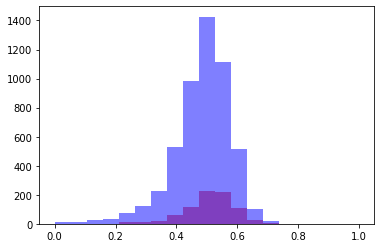

In [35]:
yhat = model.predict(X_test, verbose = True, batch_size = 512) 
yhat_cls = np.argmax(yhat, axis=1)
sum(yhat_cls)
bins = np.linspace(0, 1, 20)
_ = plt.hist(yhat[y_test==1], histtype='stepfilled', alpha=0.5, color='red', label=r"Signal", bins=bins)
_ = plt.hist(yhat[y_test==0], histtype='stepfilled', alpha=0.5, color='blue', label=r'Background', bins=bins)

In [36]:
print("Loss Events: mean: %.3f, std: %.3f" %(yhat[y_test==1].mean(),yhat[y_test==1].std()))
print("NoLoss Events: mean: %.3f, std: %.3f" %(yhat[y_test==0].mean(),yhat[y_test==0].std()))

Loss Events: mean: 0.506, std: 0.089
NoLoss Events: mean: 0.483, std: 0.094


# Let's try a BDT instead of a NN, with ADASYN Resampling

Change to XGBoost friendlier format, using all potentially useful columns, dropping Vehicle (an index) and Days (always 365, no chance of separation between loss type events)

In [65]:
#splitting up the signal and background datasets into training sets, testing sets, and validation sets. 
#This splits into 80% to be used for training and 20% testing
X = sim_sum_tot.drop(['Vehicle', 'Days'], axis=1)
y = sim_sum_tot['Loss']
ix = range(y.shape[0]) 
#X=X.drop('Loss',axis=1)
X_train, X_test, y_train, y_test, ix_train, ix_test = train_test_split(X, y, ix, train_size=0.8)
#X_train, X_val,y_train, y_val,ix_train, ix_val=train_test_split(X_train,y_train,ix_train,test_size=0.2)

In [66]:
X.columns

Index(['Distance', 'HardBrakes', 'HardAccelerations', 'NightTime_Pct',
       'VehicleType', 'Loss'],
      dtype='object')

In [67]:
adasyn = ADASYN(sampling_strategy="auto")
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)
np.bincount(y_train_adasyn)

array([20790, 20226], dtype=int64)

In [68]:
X_train_adasyn

,Distance,HardBrakes,HardAccelerations,NightTime_Pct,VehicleType,Loss
0,13823,45,170,0.000000,0,0
1,9412,70,89,0.005000,0,0
2,15405,15,138,0.002000,0,0
3,15885,62,784,0.015000,0,0
4,15588,29,79,0.000000,0,0
...,...,...,...,...,...,...
41011,14289,10,246,0.033666,1,1
41012,14400,63,265,0.000983,2,1
41013,9736,70,3,0.006619,1,1
41014,9725,68,4,0.020494,2,1


In [69]:
print('Number of training samples: {}'.format(len(X_train)))
print('Number of testing samples: {}'.format(len(X_test)))
print('ADASYN: Number of training samples: {}'.format(len(X_train_adasyn)))

print('\nNumber of signal events in training set: {}'.format(len(X_train[X_train.Loss == 1])))
print('ADASYN:Number of signal events in training set: {}'.format(len(X_train_adasyn[X_train_adasyn.Loss == 1])))
print('Number of background events in training set: {}'.format(len(X_train[X_train.Loss == 0])))
print('Fraction signal: {}'.format(len(X_train[X_train.Loss == 1])/(float)(len(X_train[X_train.Loss == 1]) + len(X_train[X_train.Loss == 0]))))
print('ADASYN: Fraction signal: {}'.format(len(X_train_adasyn[X_train_adasyn.Loss == 1])/(float)(len(X_train_adasyn[X_train_adasyn.Loss == 1]) + len(X_train_adasyn[X_train_adasyn.Loss == 0]))))

Number of training samples: 24000
Number of testing samples: 6000
ADASYN: Number of training samples: 41016

Number of signal events in training set: 3210
ADASYN:Number of signal events in training set: 20226
Number of background events in training set: 20790
Fraction signal: 0.13375
ADASYN: Fraction signal: 0.49312463428905795


In [70]:
features = X_train.columns[:-1]  # we skip the last column because it is the Loss label
features

Index(['Distance', 'HardBrakes', 'HardAccelerations', 'NightTime_Pct',
       'VehicleType'],
      dtype='object')

In [71]:
binary_bdt_param = {
    "learning_rate" : 0.15,
    "max_depth" : 6,
    "colsample_bytree" : 1.0,
    "subsample" : 1.0,
    "n_estimators" : 200,
    "feature_names" : features,
    'objective' : 'binary:logistic' # objective function
}
binary_task_param = {
    "eval_metric" : ["logloss","error"],
    "early_stopping_rounds" : 30,
    "eval_set": [(X_train_adasyn[features],y_train_adasyn), 
                 (X_test[features],y_test)]
}

binary_bdt = xgb.XGBClassifier(**binary_bdt_param)
binary_bdt.fit(X_train_adasyn[features], y_train_adasyn,
              verbose=False, **binary_task_param)

[18:45:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { feature_names } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              feature_names=Index(['Distance', 'HardBrakes', 'HardAccelerations', 'NightTime_Pct',
       'VehicleType'],
      dtype='object'),
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.15, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=0,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1.0, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [72]:
evaluated_df = X_test.copy()
evaluated_df["binary_prob"] = binary_bdt.predict_proba(X_test[features])[:,1]
print(binary_bdt.score(X_test[features],y_test))

binary_bdt.predict_proba(X_test[features])[:,1].round().sum()

0.7983333333333333


581.0

In [73]:
y_pred = binary_bdt.predict(X_test[features])
y_pred.sum()

581

In [74]:
binary_bdt.predict(X_test[features])

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [75]:
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

predictions = binary_bdt.predict(X_test[features])
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
thresholds = np.sort(binary_bdt.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(binary_bdt, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train_adasyn[features])
    # train model
    selection_model = xgb.XGBClassifier()
    selection_model.fit(select_X_train, y_train_adasyn)
    # eval model
    select_X_test = selection.transform(X_test[features])
    predictions = selection_model.predict(select_X_test)
    accuracy = accuracy_score(y_test, predictions)
    print("Loss Accuracy: %.2f"%(predictions.sum()/y_test.sum()))
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Accuracy: 79.83%
Loss Accuracy: 0.69
Thresh=0.057, n=5, Accuracy: 79.87%
Loss Accuracy: 0.63
Thresh=0.060, n=4, Accuracy: 80.07%
Loss Accuracy: 0.67
Thresh=0.077, n=3, Accuracy: 79.92%
Loss Accuracy: 0.38
Thresh=0.288, n=2, Accuracy: 82.52%
Loss Accuracy: 0.42
Thresh=0.518, n=1, Accuracy: 81.87%


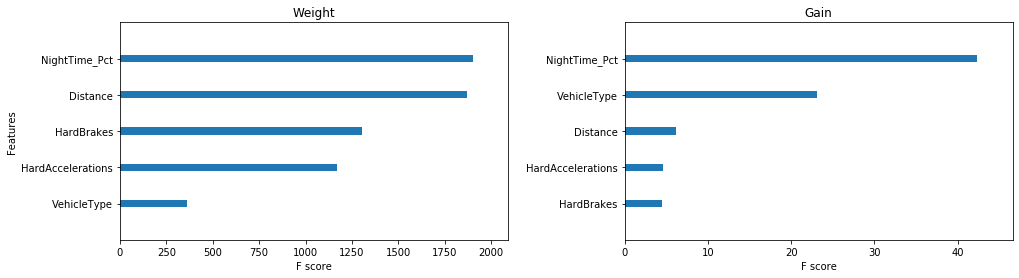

In [51]:
fig, ax_enum = plt.subplots(1,2, figsize=(16,4))
xgb.plot_importance(binary_bdt, importance_type="weight", ax=ax_enum[0], title="Weight",show_values=False, grid=False)
xgb.plot_importance(binary_bdt, importance_type="gain", ax=ax_enum[1], title="Gain", show_values=False, grid=False)
plt.ylabel("")
plt.sca(ax_enum[1])
plt.ylabel("")
plt.subplots_adjust(wspace=0.3)

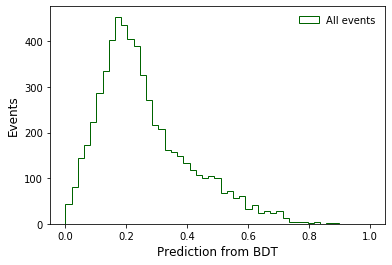

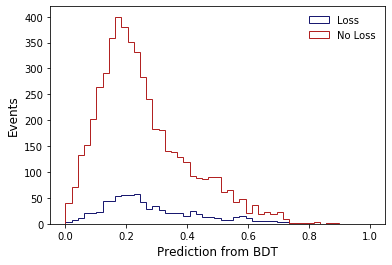

In [53]:
# plot all predictions (both signal and background)
predictions = binary_bdt.predict_proba(X_test[features])[:,1]
plt.figure();
plt.hist(predictions,bins=np.linspace(0,1,50),histtype='step',color='darkgreen',label='All events');
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);

# plot signal and background separately
plt.figure();
plt.hist(binary_bdt.predict_proba(X_test[features][y_test==1])[:,1],bins=np.linspace(0,1,50),
         histtype='step',color='midnightblue',label='Loss');
plt.hist(binary_bdt.predict_proba(X_test[features][y_test==0])[:,1],bins=np.linspace(0,1,50),
         histtype='step',color='firebrick',label='No Loss');
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);

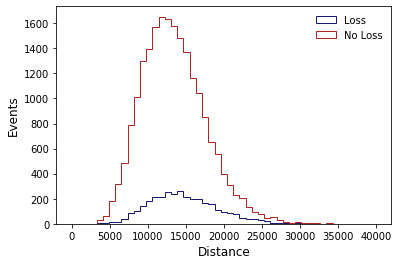

In [54]:

plt.figure();
plt.hist(X_train.Distance[X_train.Loss == 1],bins=np.linspace(0,40000,50),
         histtype='step',color='midnightblue',label='Loss');
plt.hist(X_train.Distance[X_train.Loss == 0],bins=np.linspace(0,40000,50),
         histtype='step',color='firebrick',label='No Loss');

plt.xlabel('Distance',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);

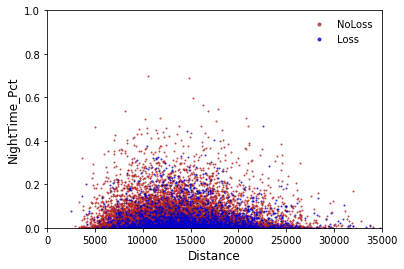

In [55]:
plt.figure();
#plt.plot(X_train_adasyn.Distance[X_train_adasyn.Loss == 0],X_train_adasyn.NightTime_Pct[X_train_adasyn.Loss == 0],
#         'o',markersize=2,color='firebrick',markeredgewidth=0,alpha=0.8,label='NoLoss');
#plt.plot(X_train_adasyn.Distance[X_train_adasyn.Loss == 1],X_train_adasyn.NightTime_Pct[X_train_adasyn.Loss == 1],
#         'o',markersize=2,color='mediumblue',markeredgewidth=0,alpha=0.8,label='Loss');

plt.plot(X_train.Distance[X_train.Loss == 0],X_train.NightTime_Pct[X_train.Loss == 0],
         'o',markersize=2,color='firebrick',markeredgewidth=0,alpha=0.8,label='NoLoss');
plt.plot(X_train.Distance[X_train.Loss == 1],X_train.NightTime_Pct[X_train.Loss == 1],
         'o',markersize=2,color='mediumblue',markeredgewidth=0,alpha=0.8,label='Loss');

plt.xlim(0,35000);
plt.ylim(0,1);
plt.xlabel('Distance',fontsize=12);
plt.ylabel('NightTime_Pct',fontsize=12);
plt.legend(frameon=False,numpoints=1,markerscale=2);